In [1]:
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pylab as plt
import matplotlib.image as mping
import os
import pandas as pd
import numpy as np
import collections
import multiprocessing
print(multiprocessing.cpu_count())
%matplotlib inline

24


In [2]:
count = 0
img_all = []
for h,_,fs in os.walk('Images/'):
    for f in fs:
        if f.endswith('.jpg'):
            img = mping.imread(h+'/'+f)
            img_all.append(img)
    count += 1
    print(count)
    if count>5:
        break

1
2
3
4
5
6


In [3]:
len(img_all)

812

In [4]:
img_shape = pd.DataFrame([i.shape for i in img_all])

In [5]:
img_shape.loc[img_shape.idxmax()[1]]

0    1632
1    2448
2       3
Name: 215, dtype: int64

In [6]:
img_ratio = img_shape[1]/img_shape[0]

In [7]:
img_ratio.idxmin()

540

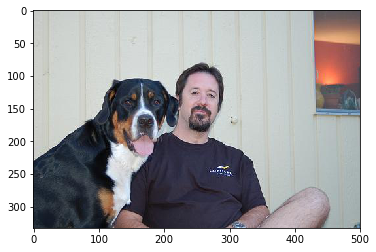

In [9]:
plt.imshow(img_all[0])

In [28]:
with open('Annotation/n02085782-Japanese_spaniel/n02085782_1085','r') as f:
    soup = BeautifulSoup(f.read(),'html.parser')

In [29]:
soup

<annotation>
<folder>02085782</folder>
<filename>n02085782_1085</filename>
<source>
<database>ImageNet database</database>
</source>
<size>
<width>260</width>
<height>331</height>
<depth>3</depth>
</size>
<segment>0</segment>
<object>
<name>Japanese_spaniel</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>10</xmin>
<ymin>2</ymin>
<xmax>247</xmax>
<ymax>323</ymax>
</bndbox>
</object>
</annotation>

In [31]:
count = 0
label_all = []
for h,_,fs in os.walk('/n/home03/xwei/Desktop/Annotation/'):
    for f in fs:
        with open(h+'/'+f,'r') as fp:
            soup = BeautifulSoup(fp.read(),'html.parser')
        label_all.append(soup)

In [11]:
label_all[102]

<annotation>
<folder>02107574</folder>
<filename>n02107574_417</filename>
<source>
<database>ImageNet database</database>
</source>
<size>
<width>500</width>
<height>500</height>
<depth>3</depth>
</size>
<segment>0</segment>
<object>
<name>Greater_Swiss_Mountain_dog</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>32</xmin>
<ymin>27</ymin>
<xmax>498</xmax>
<ymax>498</ymax>
</bndbox>
</object>
</annotation>

In [4]:
len(label_all)

20580

In [28]:
# Scrape information from AKC website
page = requests.get('https://www.akc.org/dog-breeds/sporting/page/3')
soup = BeautifulSoup(page.content,'html.parser')
name_links = soup.select_one('select."custom-select__select"').select('option')[1:]
group_map = {}
for p in name_links:
    link = p.get('value')
    l_soup = BeautifulSoup(requests.get(link).content,'html.parser')
    group_map[p.text.lower()]=l_soup.select_one('li > span > a').text

In [104]:
# Classify and correct every groups
cls = !ls Images/
cls = [c.split('-')[1].replace('_',' ') for c in cls]
groups1 = {}
groups2 = {}
first_word = [re.split(' |-',c)[0] for c in group_map.keys()]
count1 = 0
count2 = 0
for c in cls:
    if c.lower() in group_map.keys():
        groups1[c.lower()] = group_map[c.lower()]
    elif c.split(' ')[0].lower() in first_word:
        idx = first_word.index(c.split(' ')[0].lower())
        groups2[c] = list(group_map.values())[idx]
        count1 += 1
    else:
        print(c)
        count2 += 1
groups3 = {}
groups3['Pekinese'] = 'Toy Group'
groups3['Leonberg'] = 'Working Group'
groups3['African hunting dog'] = 'NAN' # Not sure about this one, suspect it is Basenji Dog
groups3['Blenheim spaniel'] = 'Toy Group' # Also known as Cavalier King Charles Spaniel
groups3['Walker hound'] = 'Hound Group' # Full name is Treeing Walker Coonhound
groups3['Scotch terrier'] = 'Terrier Group' # aka Scottish Terrier
groups3['groenendael'] = 'Herding Group' # A branch of Belgian Sheepdog
groups3['malinois'] = 'Herding Group' # Formally as Belgian Malinois
groups3['kelpie'] = 'Foundation Stock Service' # Formally as Australian Kelpie
groups3['Eskimo dog'] = 'Non-Sporting Group' # Formally as American Eskimo Dog
groups3['malamute'] = 'Working Group' # Formally as Alaskan Malamute
groups3['Brabancon griffon'] = 'Hybrid' # Brabancon and Brussels Griffon hybrid
groups3['Mexican hairless'] = 'Non-Sporting Group' # Formally as Xoloitzcuintli
groups3['dingo'] = 'NAN' # Originally considered as wolf, now believed to be a independent branch
groups3['dhole'] = 'NAN' # ALso close to wolf, not clear which superclass it belongs to
# groups2['Boston bull'] is the only one in American Kennel website starting with Boston, assume it's the one
# groups2['English springer'] is labeled correctly for the wrong reason
groups2['German shepherd'] = 'Herding Group'
groups2['German short'] = 'Sporting Group'
groups2['basset'] = 'Hound Group'
groups2['bull mastiff'] = 'Working Group'
groups2['miniature poodle'] = 'Non-Sporting Group'
groups2['standard poodle'] = 'Non-Sporting Group'
groups2['toy poodle'] = 'Non-Sporting Group' # Assuming that toy poodle is a kind of poodle anyways
# groups2['wire'] is wire-haired fox terrier, assume it's the same as wire fox terrier, though there is a group of wirehaired
groups = {**groups1,**groups2,**groups3}

Pekinese
Blenheim spaniel
Walker hound
Scotch terrier
groenendael
malinois
kelpie
Eskimo dog
malamute
Leonberg
Brabancon griffon
Mexican hairless
dingo
dhole
African hunting dog


In [111]:
pd.Series([c.split(' ')[0] for c in cls]).describe()

count       120
unique      107
top       Irish
freq          4
dtype: object

(array([15., 19., 18., 19., 19., 12., 12.,  2.,  3.,  1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

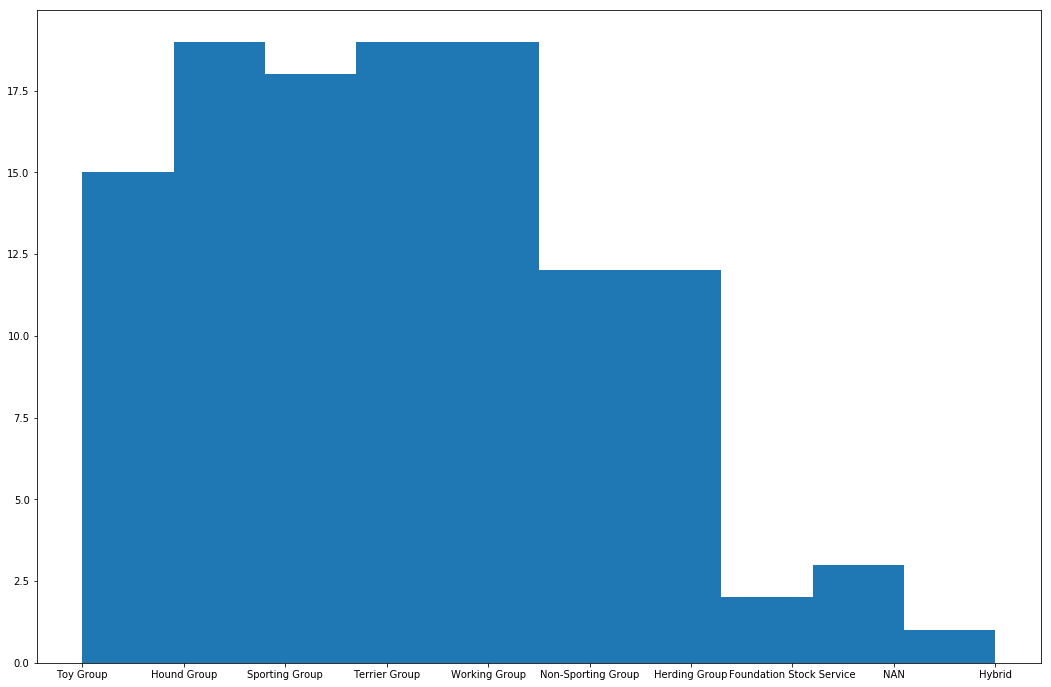

In [139]:
inv_dic = pd.DataFrame(list(groups.keys()),index=groups.values())
plt.figure(figsize=(18,12))
plt.hist(groups.values())